In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sb
import math
import statistics

import sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import statsmodels
import arch
from statsmodels.tsa.api import adfuller, seasonal_decompose, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from prophet import Prophet

import tensorflow
import keras
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam

d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Step1: Read the data, format date

In [103]:
# Read the data
data = pd.read_csv('retail_store_inventory.csv')

# select a sample of the dataset for building model, later we can extend  it to the entire dataset
# data = data[:10000]


data_description = """
There are five stores: S001, S002, S003, S004, S005, There are 20 products: P0001 to P0020, 
There are 5 categories: Groceries, Furniture, Clothing, Electronics, Toys. 
There are 4 regions: North, South, West, East. 
There are 4 weather conditions: Rain, Snow, Sunny, Cloudy.
There are 4 seasons: Spring, Autumn, Summer, Winter."""

print("Description about data:\n", data_description)
print()

# missing value information
# print("Missing values:\n", data.isna().sum())
# print()

# format date column 
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
print('Date column has been changed to date data type')
print()


Description about data:
 
There are five stores: S001, S002, S003, S004, S005, There are 20 products: P0001 to P0020, 
There are 5 categories: Groceries, Furniture, Clothing, Electronics, Toys. 
There are 4 regions: North, South, West, East. 
There are 4 weather conditions: Rain, Snow, Sunny, Cloudy.
There are 4 seasons: Spring, Autumn, Summer, Winter.

Date column has been changed to date data type



### Step2: EDA or data analysis on the following:
1. For categories: high and low demand categories, categories that faced stockout situations, seasonal fluctuations that affected the categories
2. For products: high and low demand products, products that faced stockout situations, seasonal fluctuations that affected the products

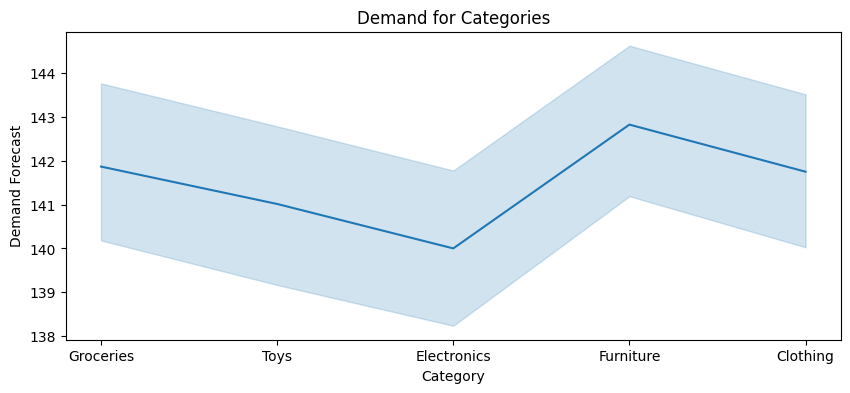

In [76]:
data_to_analyse = data[['Date', 'Product ID', 'Category', 'Inventory Level', 'Units Sold', 'Demand Forecast', 'Seasonality']]

#Categories with high and low demand 
mp.figure(figsize=(10,4))
sb.lineplot(x=data_to_analyse['Category'], y=data_to_analyse['Demand Forecast'])
mp.title('Demand for Categories')
mp.show()

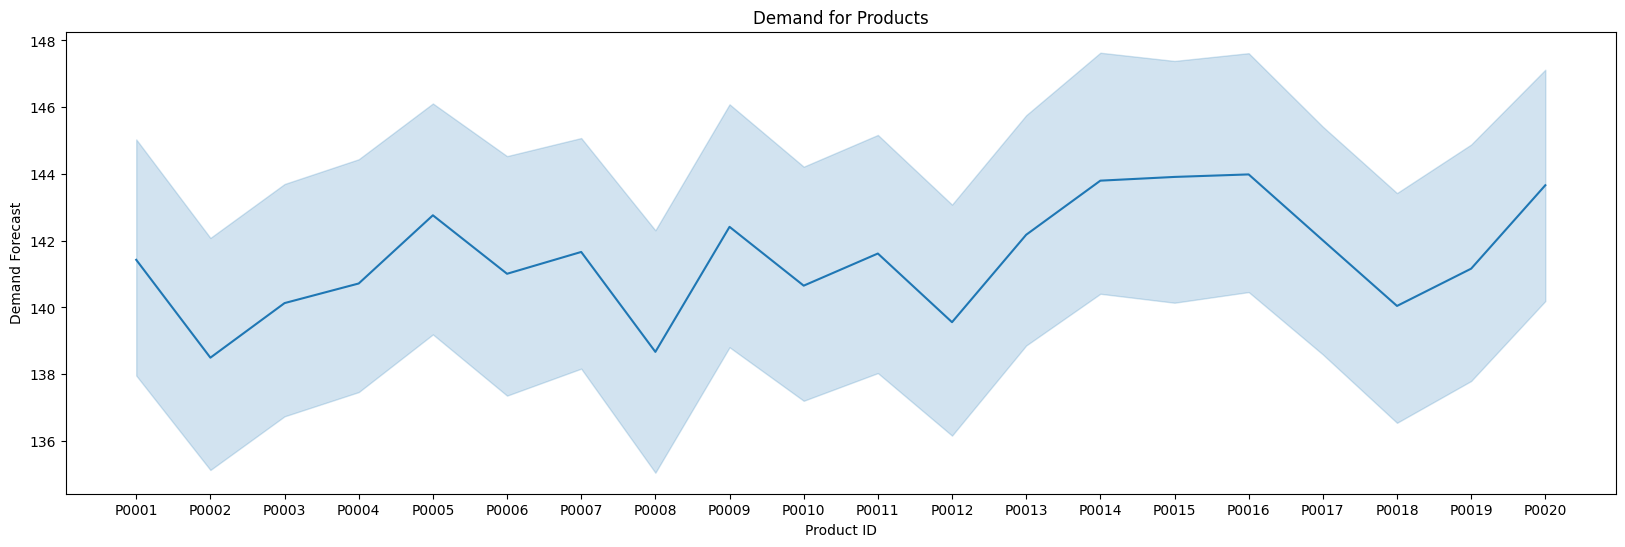

In [77]:
#Categories with high and low demand 

mp.figure(figsize=(20,6))
sb.lineplot(x=data_to_analyse['Product ID'], y=data_to_analyse['Demand Forecast'])
mp.title('Demand for Products')
mp.show()

In [78]:
#Categories that faced stock out situations
# Stockout=max(0,Demand Forecast−Inventory Level)
data_to_analyse['Stock_out']=(data_to_analyse['Demand Forecast']-data_to_analyse['Inventory Level']).clip(lower=0)

C:\Users\Ramya\AppData\Local\Temp\ipykernel_356\1326627026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_analyse['Stock_out']=(data_to_analyse['Demand Forecast']-data_to_analyse['Inventory Level']).clip(lower=0)


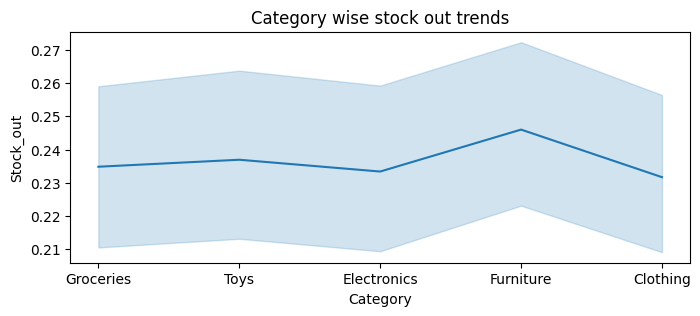

In [79]:
mp.figure(figsize=(8,3))
sb.lineplot(x=data_to_analyse['Category'], y = data_to_analyse['Stock_out'])
mp.title("Category wise stock out trends")
mp.show()

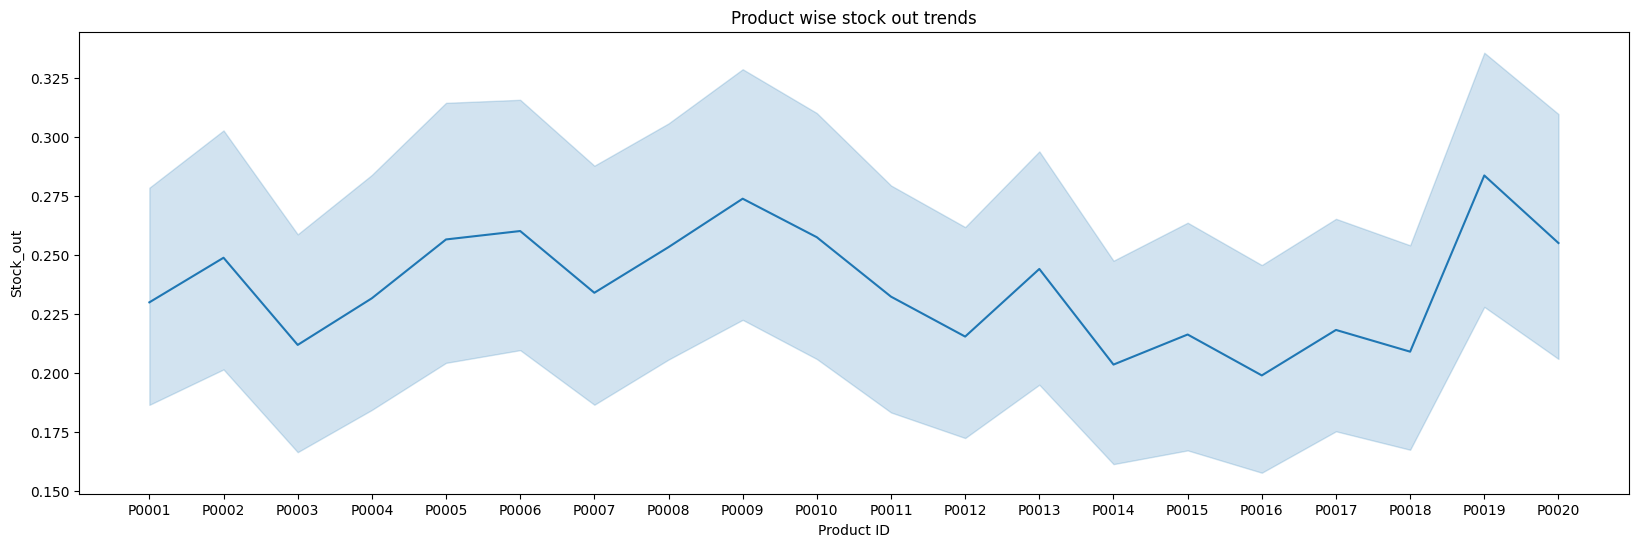

In [80]:
mp.figure(figsize=(20,6))
sb.lineplot(x=data_to_analyse['Product ID'], y = data_to_analyse['Stock_out'])
mp.title("Product wise stock out trends")
mp.show()


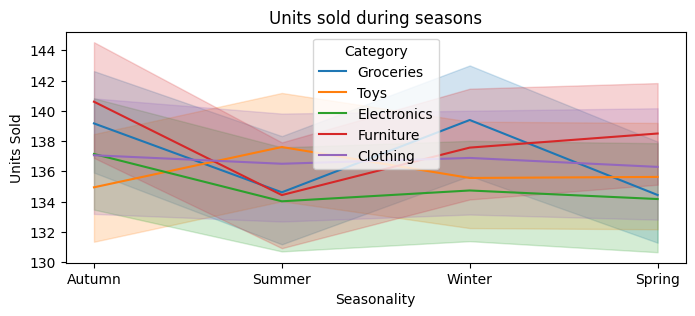

In [81]:
mp.figure(figsize=(8,3))
sb.lineplot(x=data_to_analyse['Seasonality'], y=data_to_analyse['Units Sold'], hue=data_to_analyse['Category'], markers='o')
mp.title("Units sold during seasons")
mp.show()

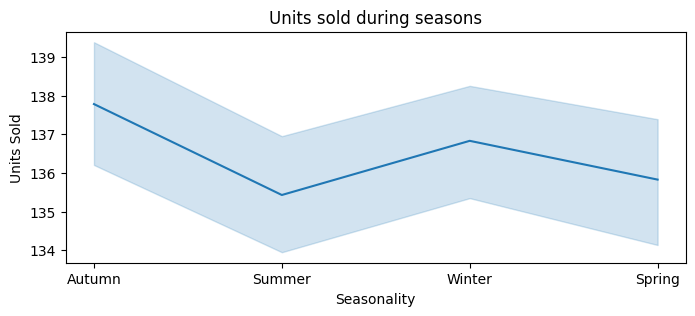

In [82]:
mp.figure(figsize=(8,3))
sb.lineplot(x=data_to_analyse['Seasonality'], y=data_to_analyse['Units Sold'])
mp.title("Units sold during seasons")
mp.show()

Category: 
high demand categories are: Furniture and clothing, low demand category is electronics
categories that faced stockout situations: Furniture and toys
seasonal fluctuations that affected the categories: high sales were in autumn, winter and low sales in summer

Products: 
high and low demand products: P0014, P0015, P0016, P0020
products that faced stockout situations: P0019, P0009, P0005, P0006, P0002, P0013

### Step3. Forecast demand using machine learning

In [104]:
# drop product id as there are 20 product id for every store 
data = data[['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality']]
print("columns we selected:", data.columns)
print()

columns we selected: Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')



In [105]:
dummy_data = pd.get_dummies(data, drop_first=True, dtype=int)
print("Converted categorical data into dummies")

#for sklearn models, we cant use date hence we will extract date, year, month and model them. 
#let's create a copy of our data into sklearn_data and proceed with Random forest, Gradient boosting model
sklearn_data = dummy_data.copy()

# Extract year, month, day from date as Random forest, Gradient boosting model will doesn’t understand time order
sklearn_data['year'] = sklearn_data['Date'].dt.year
sklearn_data['month'] = sklearn_data['Date'].dt.month
sklearn_data['day'] = sklearn_data['Date'].dt.day

# let's drop date column while building model using Random forest, Gradient boosting
sklearn_data = sklearn_data[['Inventory Level', 'Units Sold', 'Units Ordered',
       'Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion',
       'Competitor Pricing', 'Store ID_S002', 'Store ID_S003', 'Store ID_S004',
       'Store ID_S005', 'Category_Electronics', 'Category_Furniture',
       'Category_Groceries', 'Category_Toys', 'Region_North', 'Region_South',
       'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy',
       'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer',
       'Seasonality_Winter', 'year', 'month', 'day']]

Converted categorical data into dummies


### Sklearn models (Random Forest, Gradient boosting)

In [106]:
training_size = int(len(dummy_data)*0.70)

x = sklearn_data.drop(columns=['Demand Forecast'])
y = sklearn_data['Demand Forecast']

# split the data into train, validation, test 

x_train = x.iloc[:training_size]
y_train = y.iloc[:training_size]

x_test = x.iloc[training_size:]
y_test = y.iloc[training_size:]

### Machine Learning models

MAE: 7.695603023255813 and RMSE: 8.956680399025151


<Axes: >

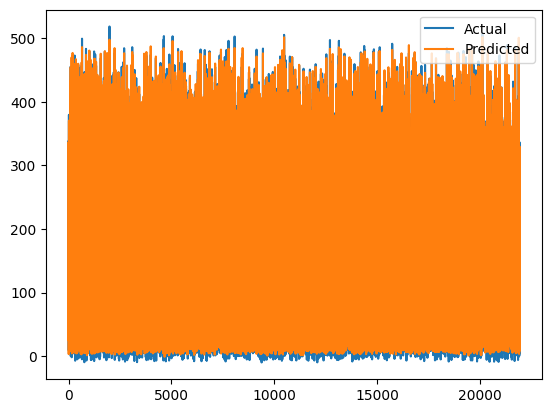

In [109]:
# Build the model
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train, y_train)

# predict the model on test data
random_forest_predictions_test = random_forest_model.predict(x_test)

#error metric on test data
random_forest_mae_test = mean_absolute_error(y_test, random_forest_predictions_test)
random_forest_rmse_test = math.sqrt(mean_squared_error(y_test, random_forest_predictions_test))

print(f'MAE: {random_forest_mae_test} and RMSE: {random_forest_rmse_test}')

# compare actual with predicted 
random_forest_predictions = pd.DataFrame(random_forest_predictions_test)
actual_vs_predicted = pd.concat([y_test.reset_index(drop=True), random_forest_predictions], axis=1)
actual_vs_predicted.columns = ['Actual', 'Predicted']
actual_vs_predicted.plot()

MAE is 7.59482959568877 and RMSE is 8.780860422204832


<Axes: >

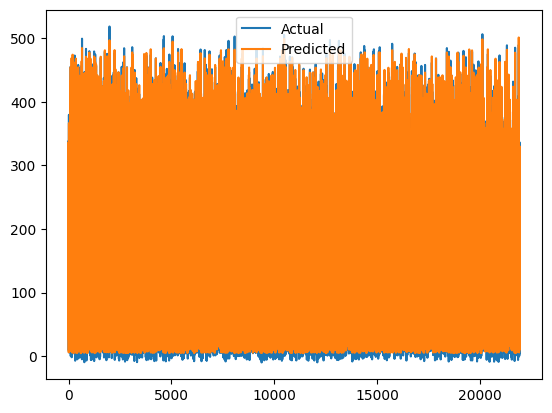

In [110]:
# Build the model
gradient_boost_model = GradientBoostingRegressor()
gradient_boost_model.fit(x_train, y_train)

# predict the model on test data
gradient_boost_predictions_test = gradient_boost_model.predict(x_test)

#error metric on test data
gradient_boost_mae_test = mean_absolute_error(y_test, gradient_boost_predictions_test)
gradient_boost_rmse_test = math.sqrt(mean_squared_error(y_test, gradient_boost_predictions_test))

print(f'MAE is {gradient_boost_mae_test} and RMSE is {gradient_boost_rmse_test}')

# compare actual with predicted 
gradient_boost_predictions = pd.DataFrame(gradient_boost_predictions_test)
actual_vs_predicted = pd.concat([y_test.reset_index(drop=True), gradient_boost_predictions], axis=1)
actual_vs_predicted.columns = ['Actual', 'Predicted']
actual_vs_predicted.plot()

### Step4: Forecast demand using Time Series Models 

In [136]:
# Data pre-processing for Time series models  (never remove date, set date as index)
time_series_data = dummy_data.copy()
time_series_data.set_index('Date', inplace=True)

In [139]:
#split the data into train, test with all independent and dependent variables
train_data = time_series_data[:training_size]
test_data = time_series_data[training_size:]

# Define the exogeneous variables
train_data_exog = train_data[['Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Holiday/Promotion', 
                              'Competitor Pricing', 'Store ID_S002', 'Store ID_S003', 'Store ID_S004', 'Store ID_S005', 
                              'Category_Electronics', 'Category_Furniture', 'Category_Groceries', 'Category_Toys', 
                              'Region_North', 'Region_South', 'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy', 
                              'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter']]

test_data_exog = test_data[['Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Holiday/Promotion', 
                            'Competitor Pricing', 'Store ID_S002', 'Store ID_S003', 'Store ID_S004', 'Store ID_S005', 
                            'Category_Electronics', 'Category_Furniture', 'Category_Groceries', 'Category_Toys', 
                            'Region_North', 'Region_South', 'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy', 
                            'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter']]

In [143]:
# check if data is stationery
def stationery_check(data):
    result = adfuller(data)
    if result[1]<0.05:
        print("Data is stationery")
    else:
        print("Data is not stationery")

# check for 3 variables Demand forecast, Inventory levels, Price

stationery_check(train_data['Demand Forecast'])
stationery_check(train_data['Inventory Level'])
stationery_check(train_data['Price'])

Data is stationery
Data is stationery
Data is stationery


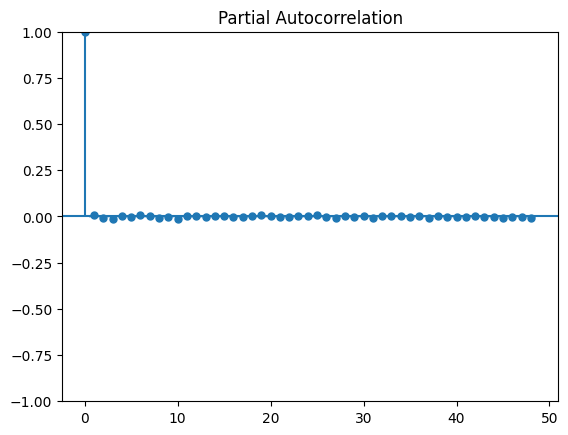

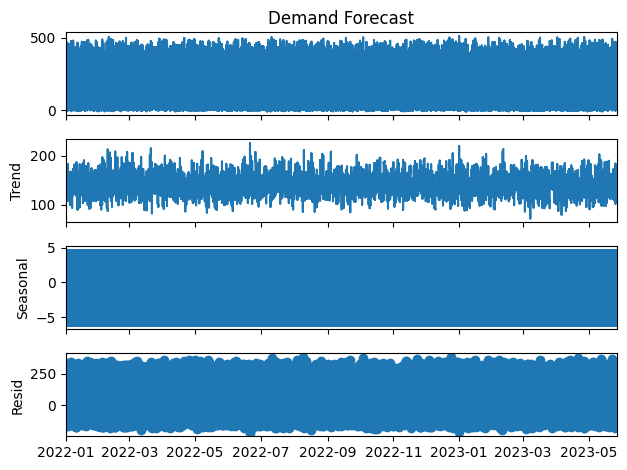

In [114]:
# check for correlation 
plot_pacf(train_data['Demand Forecast'])
mp.show()

# check for trend, seasonality, irregularity
sd = seasonal_decompose(train_data['Demand Forecast'], model='additive', period=30)
sd.plot()
mp.show()

d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  s

ARIMA model summary                                SARIMAX Results                                
Dep. Variable:        Demand Forecast   No. Observations:                51170
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -182924.001
Date:                Sat, 29 Mar 2025   AIC                         365902.003
Time:                        16:24:19   BIC                         366140.761
Sample:                             0   HQIC                        365976.712
                              - 51170                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       4.8825      0.223     21.888      0.000       4.445       5.320
Inventory Level             0.0004      0.000      1.138      0.255     

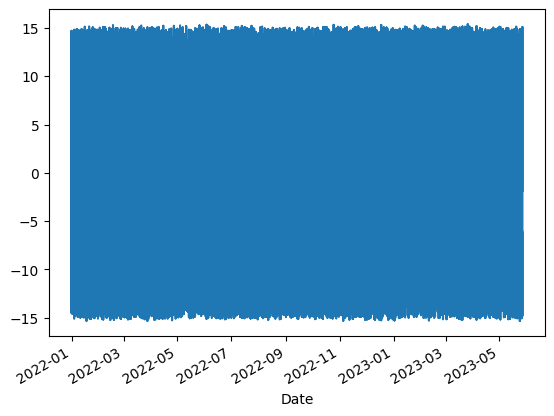

In [128]:
# ARIMA model

arima_model = ARIMA(train_data['Demand Forecast'], order=(1,0,0), exog=train_data_exog)
arima_model = arima_model.fit()
print("ARIMA model summary", arima_model.summary())
arima_model.resid.plot()

# define index range or start and end values on which predictions to be made
start_index = len(train_data)
end_index = len(train_data+test_data)-1

d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  s

ARIMA model summary                                SARIMAX Results                                
Dep. Variable:        Demand Forecast   No. Observations:                51170
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -182924.001
Date:                Sat, 29 Mar 2025   AIC                         365902.003
Time:                        16:30:18   BIC                         366140.761
Sample:                             0   HQIC                        365976.712
                              - 51170                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       4.8825      0.223     21.888      0.000       4.445       5.320
Inventory Level             0.0004      0.000      1.138      0.255     

<Axes: xlabel='Date'>

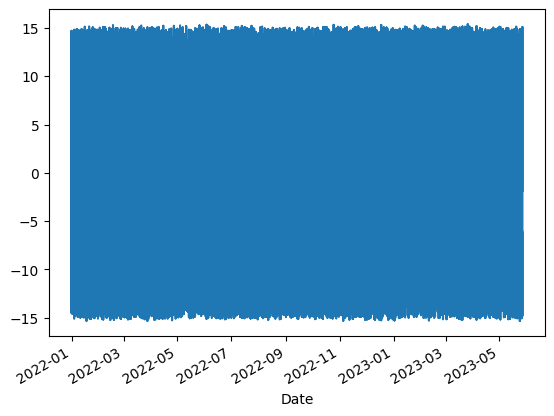

In [ ]:
# ARIMA model
arima_model = ARIMA(train_data['Demand Forecast'], order=(1,0,0), exog=train_data_exog)
arima_model = arima_model.fit()
print("ARIMA model summary", arima_model.summary())
arima_model.resid.plot()


#  define index range or start and end values on which predictions to be made
start_index = len(train_data)
end_index = len(train_data)+len(test_data)-1

# predictions on test data
arima_predictions = arima_model.predict(start=start_index, end=end_index, exog=test_data_exog)

#error metric on test data
arima_mae = mean_absolute_error(test_data['Demand Forecast'], arima_predictions)
arima_rmse = math.sqrt(mean_squared_error(test_data['Demand Forecast'], arima_predictions))

print("ARIMA model error metrics:\n")
print(f'MAE: {arima_mae} and rmse: {arima_rmse}')

# check if test data and predictions have different index
print("Test Data Index:\n", test_data.index)
print("ARIMA Predictions Index:\n", arima_predictions.index)

# reindex 
arima_predictions_reshaped = pd.Series(arima_predictions.values, index=test_data.index)

# compare actual with predicted 
actual_vs_predicted_arima = pd.concat([test_data['Demand Forecast'], arima_predictions_reshaped], axis=1)
actual_vs_predicted_arima.columns = ['Actual', 'Predicted']
actual_vs_predicted_arima.plot(title='Actual vs Predicted via Arima model')

### Step5: Forecast demand using Prophet method considering holiday, discount, pricing variables

In [161]:
# Prophet method

prophet_model = Prophet()
prophet_model.add_regressor('Holiday/Promotion')  # Add external variables
prophet_model.add_regressor('Discount')
prophet_model.add_regressor('Competitor Pricing')

# create a copy of data only for prophet method before renaming the columns else the train data format gets corrupted
prophet_data = dummy_data.copy()
prophet_data = prophet_data.rename(columns = {'Date': 'ds', 'Demand Forecast':'y'})

#split the data into train, test with all independent and dependent variables
prophet_train_data = prophet_data[:training_size]
prophet_test_data = prophet_data[training_size:]
prophet_model.fit(prophet_train_data)

#predict on test data 
prophet_predictions = prophet_model.predict(prophet_test_data)

#extract relevant columns as the model creates numerous columns
prophet_predictions = prophet_predictions[['ds', 'yhat']]

#yhat is our predictions
# prophet_predictions = prophet_predictions.rename(columns={'ds':'date', 'yhat':'predicted'})

16:35:03 - cmdstanpy - INFO - Chain [1] start processing
16:35:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet Test Data Index:
 RangeIndex(start=51170, stop=73100, step=1)
Prophet Predictions Index:
 RangeIndex(start=0, stop=21930, step=1)

After reshaping or reindexing...
Prophet Test Data Index:
 RangeIndex(start=0, stop=21930, step=1)
Prophet Predictions Index:
 RangeIndex(start=0, stop=21930, step=1)

Actual vs Predicted via Prophet method:
             y         ds        yhat
0       73.46 2023-05-27  138.197486
1      338.72 2023-05-27  137.136288
2       58.93 2023-05-27  138.182421
3        8.99 2023-05-27  137.138165
4      287.47 2023-05-27  137.562347
...       ...        ...         ...
21925   18.46 2024-01-01  135.584558
21926   48.43 2024-01-01  135.274917
21927   39.65 2024-01-01  135.353554
21928  270.52 2024-01-01  135.602525
21929    2.33 2024-01-01  136.534549

[21930 rows x 3 columns]
Actual vs predicted column names: Index(['y', 'ds', 'yhat'], dtype='object')


<Axes: title={'center': 'Actual vs Predicted via Prophet model'}, xlabel='Date'>

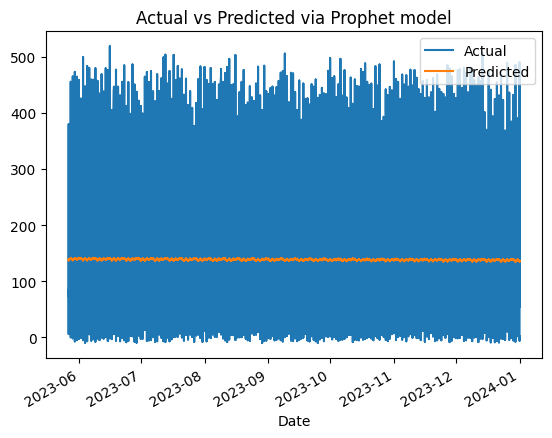

In [162]:
# check if test data and predictions have different index
print("Prophet Test Data Index:\n", prophet_test_data.index)
print("Prophet Predictions Index:\n", prophet_predictions.index)
print()

# Reset index before merging
prophet_test_data_reindexed = prophet_test_data.reset_index(drop=True)
prophet_predictions_reindexed = prophet_predictions.reset_index(drop=True)

print("After reshaping or reindexing...")

# recheck on index 
print("Prophet Test Data Index:\n", prophet_test_data_reindexed.index)
print("Prophet Predictions Index:\n", prophet_predictions_reindexed.index)
print()

# compare actual with predicted 
actual_vs_predicted_prophet = pd.concat([prophet_test_data_reindexed[['y']], 
                                         prophet_predictions_reindexed[['ds', 'yhat']]], 
                                         axis=1)
print("Actual vs Predicted via Prophet method:\n", actual_vs_predicted_prophet)
print("Actual vs predicted column names:", actual_vs_predicted_prophet.columns)
actual_vs_predicted_prophet.columns = ['Actual', 'Date', 'Predicted']
actual_vs_predicted_prophet
actual_vs_predicted_prophet.set_index('Date', inplace=True)
actual_vs_predicted_prophet.plot(title='Actual vs Predicted via Prophet model')

### Step6: Inventory optimization model
###        1. calculate optimal inventory levels (using reorder point (ROP), Safety stock (SS), Economic order quantity (EOQ)) -->
###        2. Optimize stock replenishment (decide when and how much to order)
###        3. Minimize stockouts & overstock

In [163]:
#create a copy of the dataset 
inv_opt = data.copy()

#add lead time
Lead_Time = 7

#considering 95% confidence level
Z_servicelevel = 1.65

In [19]:
#sort values by product id, date for us to calculate rolling mean and stdev
inv_opt = inv_opt.sort_values(by=['Product ID', 'Date'])

# Calculate rolling statistics for demand
inv_opt['Average_daily_demand'] = inv_opt.groupby('Product ID')['Demand Forecast'].rolling(min_periods=1, window=7).mean().reset_index(0, drop=True)
inv_opt['Demand_STDEV'] = inv_opt.groupby('Product ID')['Demand Forecast'].rolling(min_periods=1, window=7).std().reset_index(0, drop=True).fillna(0)

In [ ]:
#compute safety stock

inv_opt['Safety_stock'] = Z_servicelevel * inv_opt['Demand_STDEV']

# Compute Reorder Point (ROP) ROP = Avg_daily_demand*Lead_Time+Safety_stock
inv_opt['Reorder_point'] = (inv_opt['Average_daily_demand']*Lead_Time)+ inv_opt['Safety_stock']

#compute order quantity, any negative values become
inv_opt['Order_quantity'] = (inv_opt['Demand Forecast']-inv_opt['Inventory Level']).clip(lower=0)

In [ ]:
##example: 
# demand forecast=100, 
# inventory=120
# ROP or reorder point~70. 
# So i can recommend to the planner that when inventory drops to or below ROP level, you need to reorder/manufacture.

In [21]:
# Filter rows where reordering is needed
reorder_list = inv_opt[inv_opt['Inventory Level']<inv_opt['Reorder_point']]

#select the relevant columns
reorder_list = reorder_list[['Date', 'Store ID', 'Product ID', 'Category', 'Region', 'Safety_stock', 'Reorder_point', 'Order_quantity']]

#send the data to the user/planner
reorder_list.to_csv("reorder_recommendations.csv", index=False)

print("Inventory Optimization Complete!")

Inventory Optimization Complete!
